In [1]:
!pip install torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 35.9 MB/s eta 0:00:00


In [2]:
import networkx as nx
# import numpy as np

import torch.nn as nn
import torch.nn.functional as F
import torch
# from torch.utils.data import DataLoader

In [3]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Processing...
Done!


In [4]:
data = dataset[0]
print(data.x.shape) # [No. Nodes x Features]

# Print some of the normalized word counts of the first datapoint
data.x[0][:50]

torch.Size([2708, 1433])


tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.1111, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000])

In [5]:
# Binary mask
print(len(data.test_mask) == data.num_nodes)
data.test_mask

True


tensor([False, False, False,  ...,  True,  True,  True])

In [6]:
# Edge Connection
data.edge_index.t()

tensor([[ 633,    0],
        [1862,    0],
        [2582,    0],
        ...,
        [ 598, 2707],
        [1473, 2707],
        [2706, 2707]])

In [7]:
class GCNLayer(torch.nn.Module):
  def __init__(self, in_features, out_features, k_hop):
    super().__init__()
    self.k_hop = k_hop
    self.in_features = in_features
    self.out_features = out_features

    self.linear = nn.Linear(self.in_features, self.out_features, self.k_hop)

  def normalize_adj(self, adj):
        """Symmetrically normalize adjacency matrix."""
        adj = adj.to_sparse()
        rowsum = torch.sparse.sum(adj, dim=1) # dim=1
        # print(rowsum)

        d_inv_sqrt = torch.pow(rowsum, -0.5).flatten()
        # print(d_inv_sqrt)
        d_inv_sqrt = d_inv_sqrt.to_dense()              # START HERE

        d_inv_sqrt[torch.isinf(d_inv_sqrt)] = 0.

        d_mat_inv_sqrt = torch.diag(d_inv_sqrt)

        return torch.sparse.mm(torch.sparse.mm(adj, d_mat_inv_sqrt).T, d_mat_inv_sqrt).to_sparse()
        # return torch.matmul(torch.matmul(adj.T, d_mat_inv_sqrt.T), d_mat_inv_sqrt).to_sparse()
        # adj.dot(d_mat_inv_sqrt).transpose().dot(d_mat_inv_sqrt).tocoo()

  def chebyshev_polynomials(self, adj, k):
        """Calculate Chebyshev polynomials up to order k (k-hop). Return a list of sparse matrices (tuple representation)."""
        # print(f"Calculating Chebyshev polynomials up to order {k}...")

        adj_normalized = self.normalize_adj(adj)
        laplacian = torch.eye(adj.shape[0]).to(device) - adj_normalized
        largest_eigval, _ = torch.lobpcg(laplacian, 1, largest=True)
        scaled_laplacian = (2. / largest_eigval[0]) * laplacian - torch.eye(adj.shape[0]).to(device).to_sparse()

        t_k = list()
        t_k.append(torch.eye(adj.shape[0]).to_sparse().to(device))
        t_k.append(scaled_laplacian)

        def chebyshev_recurrence(t_k_minus_one, t_k_minus_two, scaled_lap):
            s_lap = scaled_lap
            return 2 * torch.sparse.mm(s_lap.T, t_k_minus_one) - t_k_minus_two

        for i in range(2, k+1):
            t_k.append(chebyshev_recurrence(t_k[-1], t_k[-2], scaled_laplacian))

        return t_k


  ## It calculate supports (k-hop message) by multiplying with X no need to matmul(supports, features) it become retndant
  def forward(self, features, adj_mat): #features or x
    # adj_mat = torch.ones(edge_ind).to_sparse()
    # print(f"adj_mat size {adj_mat}")

    supports =  self.chebyshev_polynomials(adj_mat, self.k_hop)

    for i in range(len(supports)):
      supports[i] = torch.sparse.mm(supports[i], features)

    output = sum(supports)
    # print(output)

    return self.linear(output)

  # def forward(self, adj_mat, features):
  #   supports =  self.chebyshev_polynomials(adj_mat, self.k_hop)[-1]
  #   return self.linear(torch.matmul(supports, features))

In [17]:
import torch
import torch.nn as nn
class GCN(torch.nn.Module):
    def __init__(self,in_fetures, out_featres, hidden_channels, k_hop):
        super(GCN, self).__init__()
        torch.manual_seed(42)

        # Initialize the layers
        self.conv1 = GCNLayer(in_fetures, hidden_channels, k_hop)
        # self.conv2 = GCNLayer(hidden_channels, hidden_channels, k_hop)
        self.out = nn.Linear(hidden_channels, out_featres)

    def forward(self, x, edge_index):
        # First Message Passing Layer (Transformation)
        x = self.conv1(x, edge_index)
        x = x.relu()
        # x = F.dropout(x, p=0.5, training=self.training)

        # # Second Message Passing Layer
        # x = self.conv2(x, edge_index)
        # x = x.relu()
        # x = F.dropout(x, p=0.5, training=self.training)

        # Output layer
        x = F.softmax(self.out(x), dim=1)
        return x

model = GCN(dataset.num_features, dataset.num_classes, hidden_channels=16, k_hop=2)
print(model)

print("Number of Params: ", sum(p.numel() for p in model.parameters()))

GCN(
  (conv1): GCNLayer(
    (linear): Linear(in_features=1433, out_features=16, bias=True)
  )
  (out): Linear(in_features=16, out_features=7, bias=True)
)
Number of Params:  23063


In [9]:
def edge_index_to_adjacency_matrix(edge_index, num_nodes=None):
    if num_nodes is None:
        num_nodes = edge_index.max() + 1

    adj_matrix = torch.zeros((num_nodes, num_nodes), dtype=torch.float)

    for i in range(edge_index.size(1)):
        source_node = edge_index[0, i]
        target_node = edge_index[1, i]
        adj_matrix[source_node, target_node] = 1.0

    return adj_matrix.to_sparse()
adj_mat_sparse = edge_index_to_adjacency_matrix(data.edge_index)
# adj_mat_sparse

In [22]:
# Initialize model
model = GCN(dataset.num_features, dataset.num_classes, hidden_channels=16, k_hop=2)

# Use GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
data = data.to(device)
adj_mat_sparse = adj_mat_sparse.to(device)

# Initialize Optimizer
learning_rate = 0.01
decay = 5e-4
optimizer = torch.optim.Adam(model.parameters(),
                             lr=learning_rate,
                             weight_decay=decay)
# Define loss function (CrossEntropyLoss for Classification Problems with
# probability distributions)
criterion = torch.nn.CrossEntropyLoss()

def train():
      model.train()
      optimizer.zero_grad()
      # Use all data as input, because all nodes have node features
      out = model(data.x, adj_mat_sparse)
      # Only use nodes with labels available for loss calculation --> mask
      loss = criterion(out[data.train_mask], data.y[data.train_mask])
      loss.backward()
      optimizer.step()
      return loss

def test():
      model.eval()
      out = model(data.x, adj_mat_sparse)
      # Use the class with highest probability.
      pred = out.argmax(dim=1)
      # Check against ground-truth labels.
      test_correct = pred[data.test_mask] == data.y[data.test_mask]
      # Derive ratio of correct predictions.
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())
      return test_acc

losses = []
for epoch in range(0, 501):
    loss = train()
    losses.append(loss)
    if epoch % 100 == 0:
      print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

Epoch: 000, Loss: 1.9461
Epoch: 100, Loss: 1.4754
Epoch: 200, Loss: 1.2769
Epoch: 300, Loss: 1.2517
Epoch: 400, Loss: 1.2464
Epoch: 500, Loss: 1.2448


<Axes: >

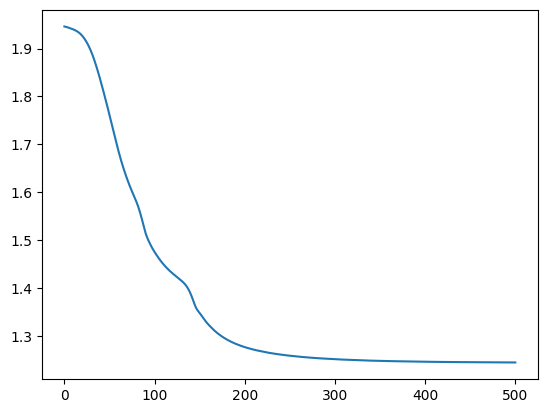

In [23]:
# Visualize learning (training loss)
import seaborn as sns
losses_float = [float(loss.cpu().detach().numpy()) for loss in losses]
# loss_indices = [i for i,l in enumerate(losses_float)]
plt = sns.lineplot(data=losses_float)
plt

In [24]:
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.5950
